# Анализ случаев Covid-19

Данные были получены из открытого источника `https://data.world` и загружен файл для анализа `COVID-19 Cases.csv`

Описание датасета:

  - `case_type` - содержит два типа случая: подтвержден случай, смерть
  - `people_total_tested_count` - количество протестированных людей (кумулятивное значение)
  - `cases` - количество случаев
  - `difference` - у скольких людей за каждый день был положительный результат теста
  - `date` - дата
  - `combined_key` - комбинация параметров Admin 2, State_Province и Country_Region
  - `country_region` - регион, предусмотрен для всех стран
  - `province_state` - штат, предусмотрено для Австралии, Канады, Китая, Дании, Франции, Нидерландам, Соединенному Королевству и США
  - `admin2` - наименование города, предусмотрено только для США
  - `iso2` - маркировка региона 
  - `iso3` - маркировка региона
  - `fips` - только в США, 5-значный федеральный стандарт обработки информаци
  - `lat` - широта
  - `long` - долгота
  - `population_count` - численность населения
  - `people_hospitalized_cumulative_count` - количество госпитализированных людей (кумулятивное значение)
  - `data_source` - ресурс с которого были получены данные
  - `prep_flow_runtime` - дата начала ETL процесса

**Цель:** Выявить период роста и спада эпидемии, в каких странах наибольшее количество случаев заражения и смертей. Выявть зависимость между количеством случаев и численностью населения.

Анализ данных будет выполнен в несколько этапов:

**1.Изучение общей информации:**
- Изучение размера датафрейма: количество столбцов, строк, стиль вывода
- Изучение типа данных
- Проверка на пропуски 
- Проверка на явные дубликаты

**2.Предобработка данных:**
- Преобразование данных
- Проверка на уникальные значения
- Заполнение пропусков
- Добавление столбцов в датафрейм

**3.Исследовательский анализ:**
 - Изучение аномалий и выбросов
 - Распределение случаев
 - Выявить Топ-15 стран по наибольшему количеству случаев
 - Выявить Топ-5 стран по наименьшему количеству случаев
 - Исследование случаев в штатах США
 - Корреляция данных
 
 **4.Общие выводы**

## Изучение общей информации

In [1]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [3]:
#импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
from plotly import graph_objects as go
%matplotlib inline
import json

from datetime import datetime, date, time, timedelta, timezone
from folium import Map, Choropleth
from folium import Marker
from folium.plugins import MarkerCluster

#игнорируем ошибки
import warnings
warnings.filterwarnings('ignore')

#выводим столбцы и строки полностью, формат округлен
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

#выводим значения без сокращений
pd.set_option('display.max_colwidth', None)

In [4]:
#прочитаем и сохраним в переменную фрейм
df = pd.read_csv('covid_19.csv')

In [5]:
#создадим функцию для ознакомления с датафреймом

def pre_processing(data):
    
    #выведем первые пять строк фрейма
    head_info = display(data.head())
    print('-'*50)
    
    #выведем общую информацию о фрейме
    inform = data.info()
    print('-'*50)
    
    #проверим наличие явных дубликатов
    dub_count = data.duplicated().sum()
    print('Количество дубликатов равно', dub_count)

In [6]:
#изучим визуально фрейм вызвав функцию pre_processing

pre_processing(df)

исCase_Type  People_Total_Tested_Count  Cases  Difference       Date  \
0   Confirmed                        NaN      6           0  5/22/2020   
1   Confirmed                        NaN      0           0   2/3/2020   
2      Deaths                        NaN      0           0   3/1/2020   
3   Confirmed                        NaN     23           0  4/21/2020   
4      Deaths                        NaN     56           0  5/11/2020   

          Combined_Key       Country_Region Province_State Admin2 iso2 iso3  \
0       Western Sahara       Western Sahara            NaN    NaN   EH  ESH   
1          Switzerland          Switzerland            NaN    NaN   CH  CHE   
2               Cyprus               Cyprus            NaN    NaN   CY  CYP   
3  Antigua and Barbuda  Antigua and Barbuda            NaN    NaN   AG  ATG   
4             Thailand             Thailand            NaN    NaN   TH  THA   

   FIPS   Lat   Long  Population_Count  People_Hospitalized_Cumulative_Count  \
0   NaN 24.22 -12.89        597,330.00                                   NaN   
1   NaN 46.82   8.23      8,654,618.00                                   NaN   
2   NaN 35.13  33.43      1,207,361.00                                   NaN   
3   NaN 17.06 -61.80         97,928.00                                   NaN   
4   NaN 15.87 100.99     69,799,978.00                                   NaN   

                                                                         Data_Source  \
0  2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE   
1  2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE   
2  2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE   
3  2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE   
4  2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE   

      Prep_Flow_Runtime  
0  6/4/2020 11:15:39 PM  
1  6/4/2020 11:15:39 PM  
2  6/4/2020 11:15:39 PM  
3  6/4/2020 11:15:39 PM  
4  6/4/2020 11:15:39 PM

--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950670 entries, 0 to 950669
Data columns (total 18 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   исCase_Type                           950670 non-null  object 
 1   People_Total_Tested_Count             6048 non-null    float64
 2   Cases                                 950670 non-null  int64  
 3   Difference                            950670 non-null  int64  
 4   Date                                  950670 non-null  object 
 5   Combined_Key                          950670 non-null  object 
 6   Country_Region                        950670 non-null  object 
 7   Province_State                        901260 non-null  object 
 8   Admin2                                878580 non-null  object 
 9   iso2                                  949590 non-null  object 
 10  iso3             

<Axes: >

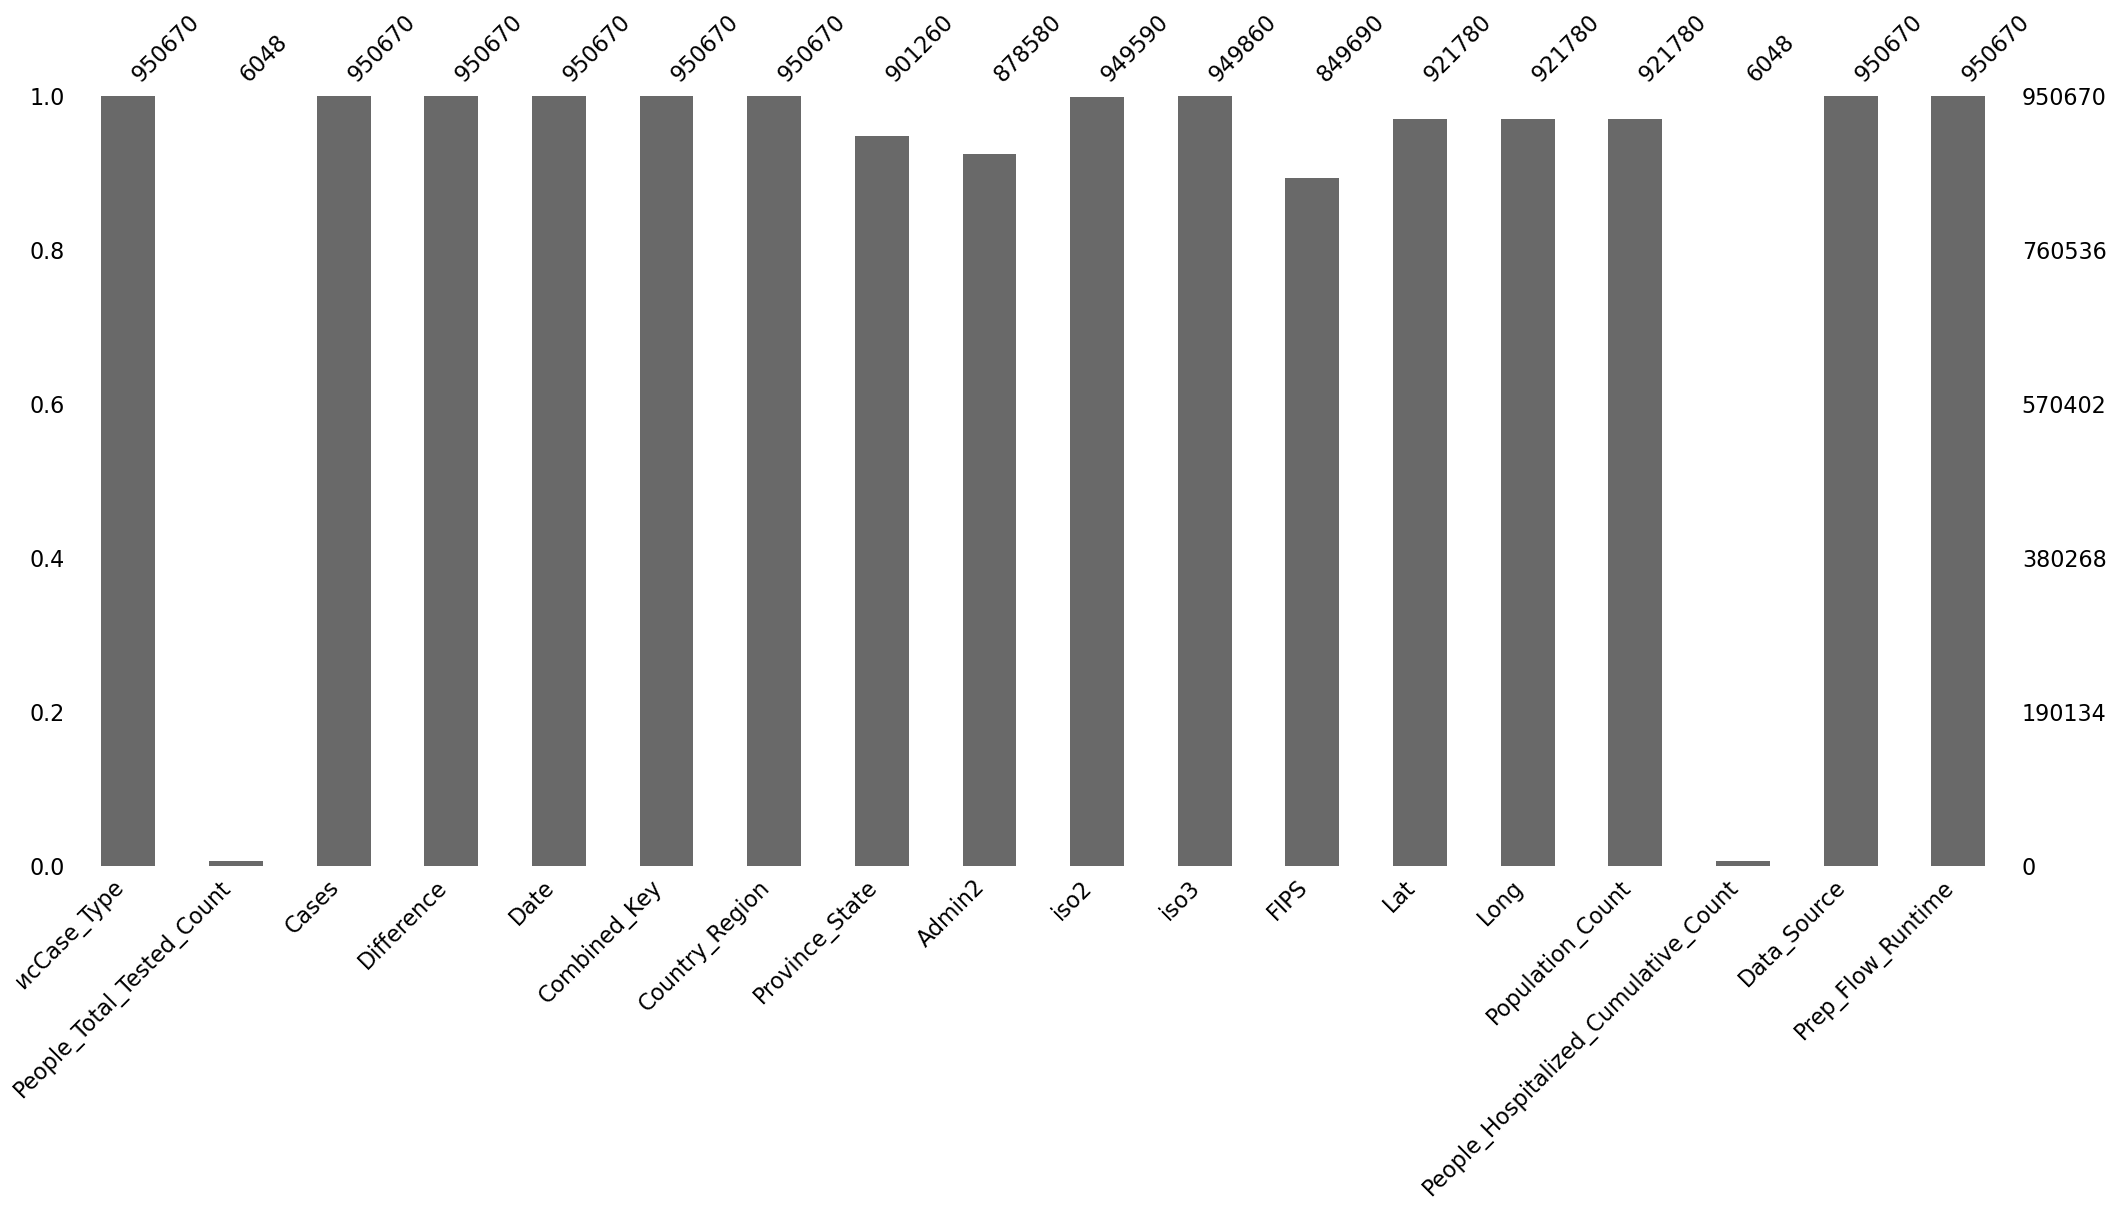

In [7]:
#для удобства визуализируем пропуски

msno.bar(df)

_**Промежуточный вывод:** При первом ознакомлении с датафреймом, мы видим, что в данных 950 670 строк, 18 столбцов, наименование которых необходимо привести к змеиному типу._

_В данных нет явных дубликатов. Стобцы №4 и №16 необходимо привести к формату `date`._

_Пропуски есть в следующих столбцах: №1 и №15 - составляют 99%, которые заполнить невозможно, т.к. у нас нет данных о количестве поступивших людей для проведения теста. Пропуски с №7 по №11 столбцы можно обосновать тем, что маркировка предоставляется для отдельных видов регионов, что указано в описании к датафрейму. Здесь пропуски заменим на обозначение NI (no information), а также для столбца FIPS - пропуски заменим на 0. Столбцы №12, №13 и №14 рассмотрим детально и примем решение касательно их заполнения._


## Предобработка данных

In [8]:
#приведем наименование столбов к змеиному типу

df.columns = map(str.lower, df.columns)
df = df.rename(columns={'исcase_type':'case_type'})

In [9]:
#заполним пропуски в столбцах 7-9 на маркировку NI (no information),  а в столбце FIPS на 0

df[['province_state', 'admin2', 'iso2', 'iso3']] = df[['province_state', 'admin2', 'iso2', 'iso3']].fillna("NI")
df['fips'] = df['fips'].fillna(0)

In [10]:
#посмотрим на пропуски, которые есть в столбце population_count

nulls = df.query('population_count.isna()')
nulls.head()
nulls.tail()

case_type  people_total_tested_count  cases  difference       date  \
950574     Deaths                        NaN      0           0  1/22/2020   
950591     Deaths                        NaN      0           0  1/22/2020   
950635  Confirmed                        NaN      0           0  1/22/2020   
950638  Confirmed                        NaN      0           0  1/22/2020   
950657     Deaths                        NaN      0           0  1/22/2020   

                       combined_key country_region province_state      admin2  \
950574       Out of IN, Indiana, US             US        Indiana   Out of IN   
950591    Unassigned, Tennessee, US             US      Tennessee  Unassigned   
950635  Out of PA, Pennsylvania, US             US   Pennsylvania   Out of PA   
950638       Unassigned, Nevada, US             US         Nevada  Unassigned   
950657      Out of VA, Virginia, US             US       Virginia   Out of VA   

       iso2 iso3  fips  lat  long  population_count  \
950574   US  USA  0.00  NaN   NaN               NaN   
950591   US  USA  0.00  NaN   NaN               NaN   
950635   US  USA  0.00  NaN   NaN               NaN   
950638   US  USA  0.00  NaN   NaN               NaN   
950657   US  USA  0.00  NaN   NaN               NaN   

        people_hospitalized_cumulative_count  \
950574                                   NaN   
950591                                   NaN   
950635                                   NaN   
950638                                   NaN   
950657                                   NaN   

                                                                              data_source  \
950574  2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE   
950591  2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE   
950635  2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE   
950638  2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE   
950657  2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE   

           prep_flow_runtime  
950574  6/4/2020 11:15:39 PM  
950591  6/4/2020 11:15:39 PM  
950635  6/4/2020 11:15:39 PM  
950638  6/4/2020 11:15:39 PM  
950657  6/4/2020 11:15:39 PM

Мы видим, что пропуски есть для городов Китая (Макао, Гонконг), а также для США, но в которых есть маркировка, что место находится за пределами штата. Здесь мы также видим, что для этих строк отсутствует долгота и широта населенного пункта.

In [11]:
#приведем столбец date к формату date

problem_regions = pd.pivot_table(nulls,
                                 values=['cases'],
                                 index=['country_region', 'province_state', 'admin2'],
                                 aggfunc={'cases': "sum"}).reset_index()

problem_regions

country_region province_state      admin2  cases
0            China      Hong Kong          NI  76535
1            China          Macau          NI   3799
2      Cruise Ship             NI          NI  81265
3               US        Alabama   Out of AL      0
4               US        Alabama  Unassigned   1304
..             ...            ...         ...    ...
102             US  West Virginia  Unassigned    202
103             US      Wisconsin   Out of WI      0
104             US      Wisconsin  Unassigned     76
105             US        Wyoming   Out of WY      0
106             US        Wyoming  Unassigned    392

[107 rows x 4 columns]

Исходя из полученной таблицы, мы видим, что помимо двух городов Китая и поселков США, в данных есть круизный лайнер. В данном случае, мы выполним следующие действия:
  1. Заполним пропуски для Китая - население Гонконга составляет 7 528 265 человек, координаты (22.255 с.ш : 114.195 в.д.), Макао - 676 283 человека, координаты (22.1202 с.ш : 113.3245 в.д.). Данные взяты за 2020 год.
  2. Круизный лайнер мы примем за `Diamond Princess`, первый лайнер, на борту которого была зафиксирована вспышка Covid-19 в 2020 году. Из открытых источников известно, что количество пассажиров составляло 3 711 человек, помещен был на карантин в порту Йокогамы, координаты (35.4333 с.ш : 139.65 в.д.)
  3. Для поселений, которые находятся за пределами штатов, мы заполним пропуски населения медианной, а пропуски в координатах - медианным значением штатов, таким образом данные на карте отобразяться именно в том штате, к которому привязанны случаи заражения.

In [12]:
#заполняем пропуски для Китая

df.update(df.loc[(df['population_count'].isnull()) & (df['province_state'] == "Hong Kong"), 'population_count'].fillna(7528265))
df.update(df.loc[(df['population_count'].isnull()) & (df['province_state'] == "Macau"), 'population_count'].fillna(676283))

df.update(df.loc[(df['lat'].isnull()) & (df['province_state'] == "Hong Kong"), 'lat'].fillna(22.255))
df.update(df.loc[(df['lat'].isnull()) & (df['province_state'] == "Macau"), 'lat'].fillna(22.1202))

df.update(df.loc[(df['long'].isnull()) & (df['province_state'] == "Hong Kong"), 'long'].fillna(114.195))
df.update(df.loc[(df['long'].isnull()) & (df['province_state'] == "Macau"), 'long'].fillna(113.3245))

In [13]:
#заполняем пропуски для круизного лайнера

df.update(df.loc[(df['population_count'].isnull()) & (df['country_region'] == "Cruise Ship"), 'population_count'].fillna(3711))
df.update(df.loc[(df['lat'].isnull()) & (df['country_region'] == "Cruise Ship"), 'lat'].fillna(35.4333))
df.update(df.loc[(df['long'].isnull()) & (df['country_region'] == "Cruise Ship"), 'long'].fillna(139.65))

In [14]:
#заполняем пропуски для неизвестных поселков США (население)

df['population_count'] = df['population_count'].fillna(df['population_count'].median())

In [15]:
#пишем цикл для определения медианны по широте

for t in df['province_state'].unique():
    df.loc[(df['province_state'] == t) & (df['lat'].isna()), 'lat'] = \
    df.loc[(df['province_state'] == t), 'lat'].median()

In [16]:
#пишем цикл для определения медианны по долготе

for t in df['province_state'].unique():
    df.loc[(df['province_state'] == t) & (df['long'].isna()), 'long'] = \
    df.loc[(df['province_state'] == t), 'long'].median()

<Axes: >

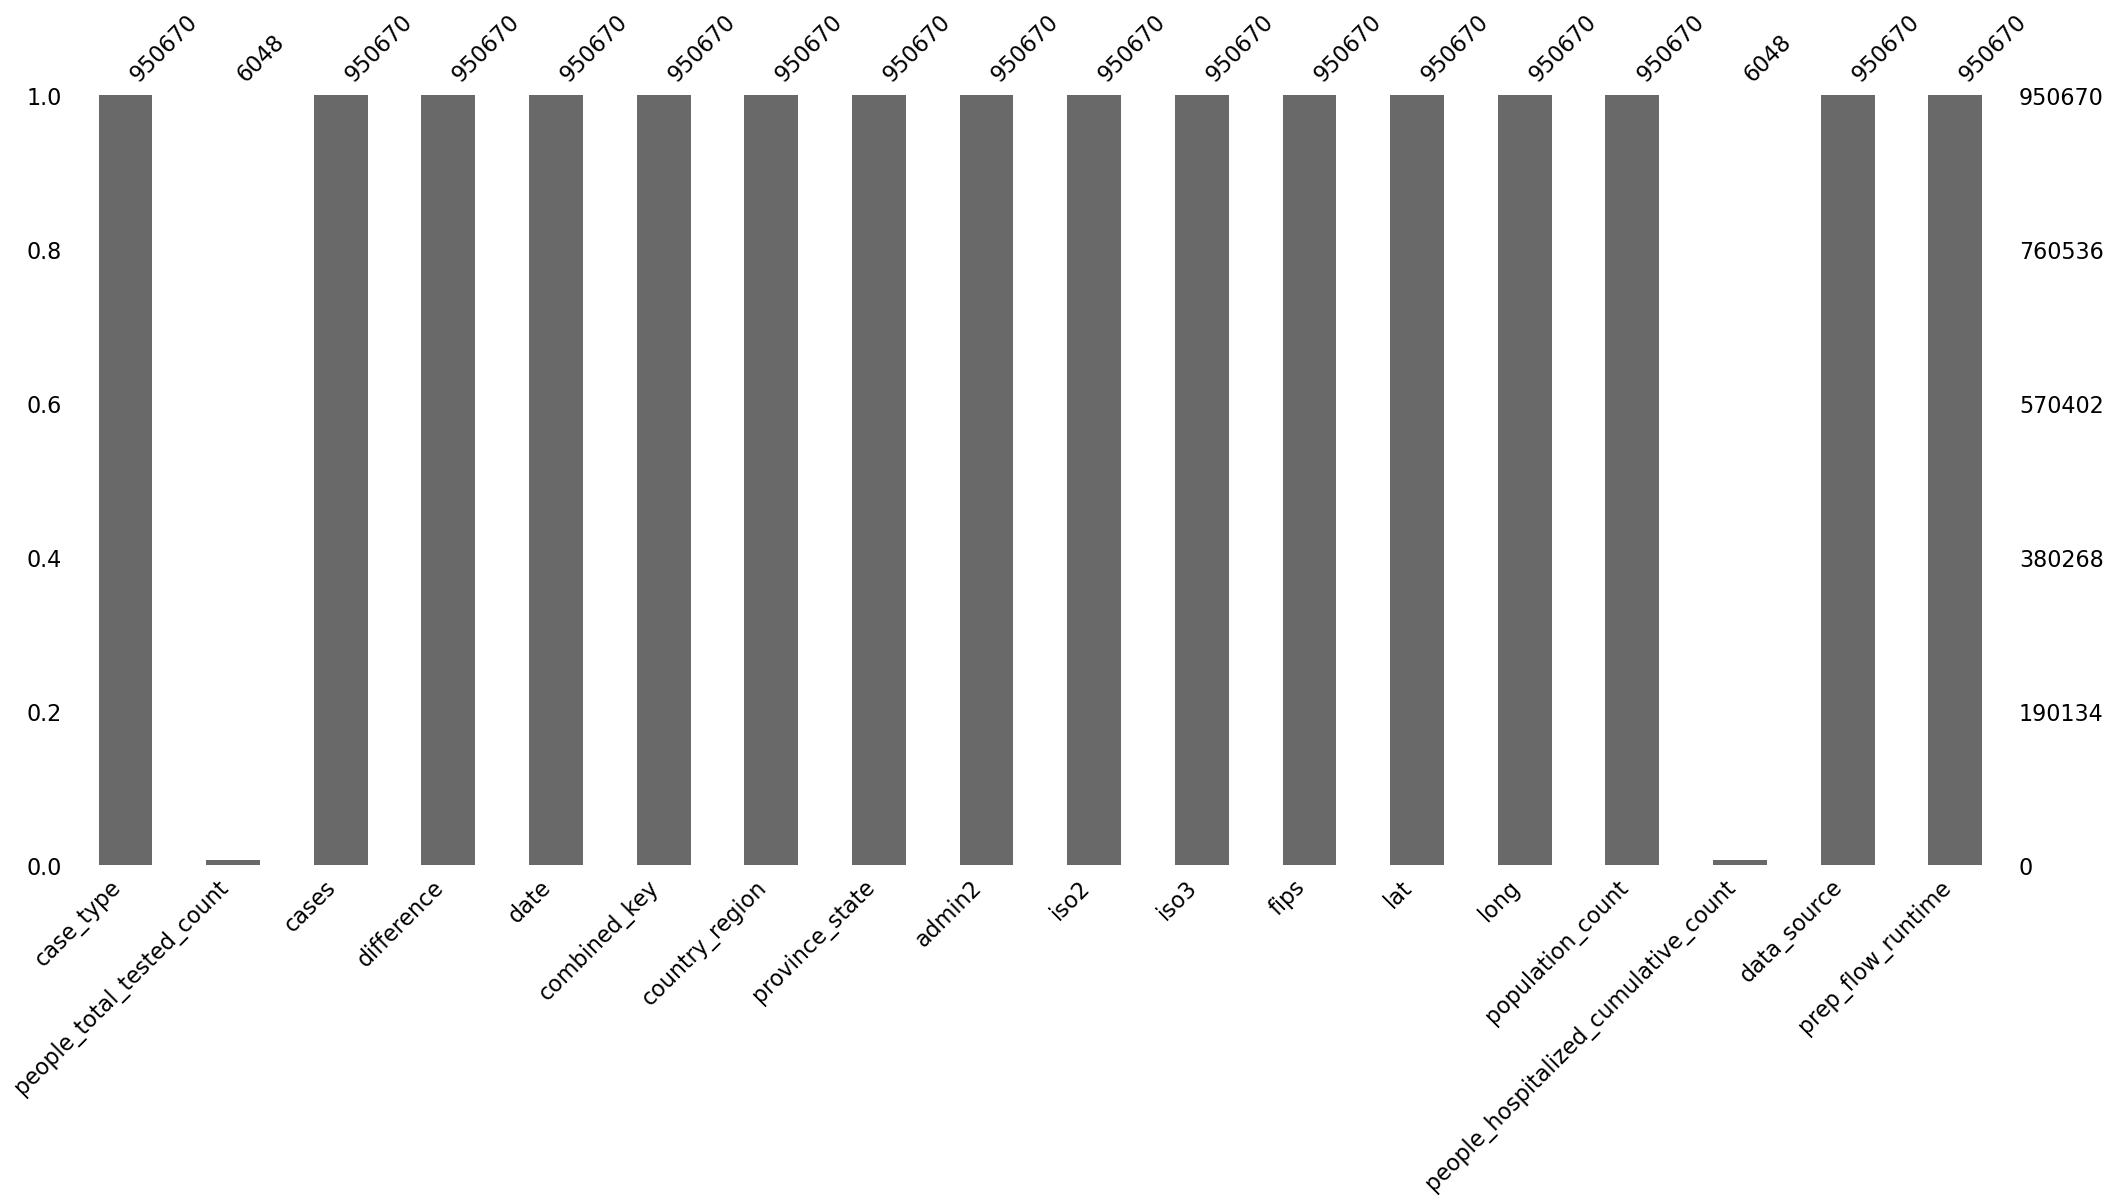

In [17]:
#проверим заполнение пропусков

msno.bar(df)

Все необходимые пропуски в столбцах заполнены.

In [18]:
#приведем столбец date к формату datetime

df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

In [19]:
#напишем функцию, которая выведет уникальные значения для всех столбцов

def col_unique(data):
    ''' На вход передаем текущий фрейм и создаем столбец в который попадут уникальные значения
    и  их количество. Переворачиваем таблицу для удобства чтения и сортируем в порядке возрастания'''
    
    df = data
    values = pd.DataFrame()
    
    for col in df.columns:
        values[col] = [df[col].unique(), df[col].nunique()]
    
    return values.transpose().sort_values(by=1, ascending=True).rename(
        {0:'Уникальные значения', 1:'Кол-во уникальных значений'}, axis=1)


In [20]:
#применим функцию в датафрейму

col_unique(df)

Уникальные значения  \
prep_flow_runtime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                [6/4/2020 11:15:39 PM]   
data_source                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

_Из полученной таблицы мы видим:_
  1. _Данные были выгруженны одним днём, 4 июня 2020 года, ночью. По этому данный столбец мы не будем приводить к типу `date`_
  2. _Данные выгруженны с одного ресурса "2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE"_
  3. _Данные представленны для двух случаев: confirmed - подтвержденный вирус (положительный тест), deaths - случаи смерти_
  4. _Период, за который были собраны данные составляет 135 дней._
  5. _Данные собраны для 186 стран и 1 круизного корабля._
  6. _Визуально аномалии и выбросы не наблюдаются._

In [21]:
#узнаем начальную и последнюю дату сбора

print(f"Первая дата сбора данных: {df['date'].min()}")
print(f"Последняя дата сбора данных: {df['date'].max()}")

Первая дата сбора данных: 2020-01-22 00:00:00
Последняя дата сбора данных: 2020-06-04 00:00:00


Последняя дата сбора совпадает с датой выгрузки данных.

## Исследовательский анализ данных

### Поиск выбросов и аномалий

In [22]:
#с помощью describe изучим данные всего фрейма

df.describe()

people_total_tested_count      cases  difference       fips        lat  \
count                   6,048.00 950,670.00  950,670.00 950,670.00 950,670.00   
mean                  167,299.61     273.52        7.39  27,113.26      37.18   
std                   264,334.10   5,187.50      166.49  17,139.37       9.68   
min                         3.00       0.00  -10,034.00       0.00     -51.80   
25%                    29,807.00       0.00        0.00  13,233.00      34.08   
50%                    77,987.00       0.00        0.00  27,135.00      38.21   
75%                   189,767.75       4.00        0.00  42,035.00      41.83   
max                 2,293,032.00 614,941.00   33,274.00  56,045.00      71.71   

            long  population_count  people_hospitalized_cumulative_count  
count 950,670.00        950,670.00                              6,048.00  
mean      -83.56      2,194,784.92                              2,625.72  
std        38.67     26,214,181.82                              9,465.12  
min      -174.16             86.00                                  0.00  
25%       -97.79         12,268.00                                  0.00  
50%       -89.19         29,709.00                                325.50  
75%       -81.89         92,987.00                              1,697.50  
max       178.06  1,380,004,385.00                             89,995.00

Мы видим такие выбросы как: количество протестированных людей более 2 млн., 614 тысяч подтвержденных случаев, население 1.38 млрд. Данные цифры можно обосновать тем, что в данных есть такие густонаселенные страны как Китай и Индия.

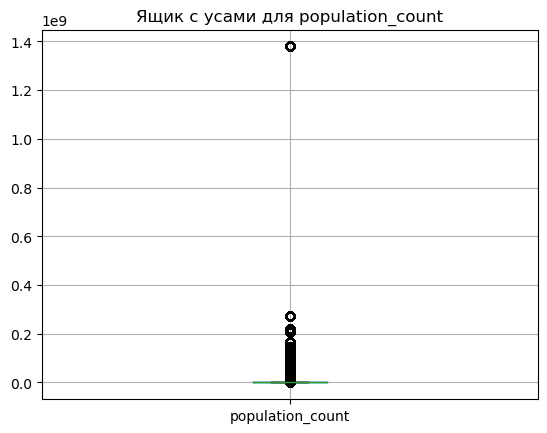

In [23]:
#построим ящик с усами для population_count

df.boxplot(column='population_count')
plt.title('Ящик с усами для population_count')
plt.show()

Из данных видно, что есть очень много населенных пунктов с количеством людей менее 15 000 человек, а также есть выбросы такие как 1.4 млрд. В данном случае выбросы удалять нерационально, т.к. нам необходимо выполнить анализ и увидить распределение случаев по странам и его населению.
Также из таблицы видно, что в столбце `population_count` указано население для региона или штата, по этому мы добавим столбец в датафрейм, где посчитаем общее количество населения для каждой страны.

In [24]:
#оформим сводную таблицу, где сгруппируем данные по странам и их регионам

by_state = pd.pivot_table(df,
                            values=['population_count'],
                            index=['country_region', 'province_state'],
                            aggfunc={'population_count': "mean"}).reset_index()

by_state.columns = ['country_region', 'state', 'population']
by_state

country_region state    population
0           Afghanistan    NI 38,928,341.00
1               Albania    NI  2,877,800.00
2               Algeria    NI 43,851,043.00
3               Andorra    NI     77,265.00
4                Angola    NI 32,866,268.00
..                  ...   ...           ...
313  West Bank and Gaza    NI  5,101,416.00
314      Western Sahara    NI    597,330.00
315               Yemen    NI 29,825,968.00
316              Zambia    NI 18,383,956.00
317            Zimbabwe    NI 14,862,927.00

[318 rows x 3 columns]

In [25]:
#оформим сводную таблицу, где сгруппируем население только по странам

by_country = pd.pivot_table(by_state,
                          values=['population'],
                          index=['country_region'],
                          aggfunc={'population': "sum"}).reset_index()

by_country.columns = ['country_region', 'population']
by_country

country_region    population
0           Afghanistan 38,928,341.00
1               Albania  2,877,800.00
2               Algeria 43,851,043.00
3               Andorra     77,265.00
4                Angola 32,866,268.00
..                  ...           ...
182  West Bank and Gaza  5,101,416.00
183      Western Sahara    597,330.00
184               Yemen 29,825,968.00
185              Zambia 18,383,956.00
186            Zimbabwe 14,862,927.00

[187 rows x 2 columns]

In [26]:
#объединим таблицы, чтобы добавить столбец population в датафрейм

df = df.merge(by_country, on="country_region", how="left")

#проверим вывод таблицы
df.head(2)

case_type  people_total_tested_count  cases  difference       date  \
0  Confirmed                        NaN      6           0 2020-05-22   
1  Confirmed                        NaN      0           0 2020-02-03   

     combined_key  country_region province_state admin2 iso2 iso3  fips   lat  \
0  Western Sahara  Western Sahara             NI     NI   EH  ESH  0.00 24.22   
1     Switzerland     Switzerland             NI     NI   CH  CHE  0.00 46.82   

    long  population_count  people_hospitalized_cumulative_count  \
0 -12.89        597,330.00                                   NaN   
1   8.23      8,654,618.00                                   NaN   

                                                                         data_source  \
0  2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE   
1  2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE   

      prep_flow_runtime   population  
0  6/4/2020 11:15:39 PM   597,330.00  
1  6/4/2020 11:15:39 PM 8,654,618.00

### Распределение случаев

Посмотрим как распределены случаи смертей и заражений по всему миру за весь период данных.

In [27]:
#сгруппируем случаи по количеству людей

cases_sum = (df
               .groupby('case_type')['cases']
               .sum()
               .reset_index())
cases_sum.columns = ['case_type', 'total_sum']
cases_sum

case_type  total_sum
0  Confirmed  244187571
1     Deaths   15838408

In [28]:
print(f'Общее количество случаев составляет: {sum(cases_sum["total_sum"])}')

Общее количество случаев составляет: 260025979


In [29]:
#строим круговую диаграмму

fig = go.Figure(data=[go.Pie(labels=cases_sum['case_type'],
                           values=cases_sum['total_sum'],
                           pull = [0.1, 0])])
      

fig.update_layout(title='Распределение количества заболевших и умерших от Covid-19',
                  title_x=0.5,
                  width=800, 
                  height=600,
                  annotations=[dict(x=1.12,
                                    y=1.05,
                                    text='Тип случая',
                                    showarrow=False)])
fig.show()

За пять месяцев 2020 года количество умерших от Covid-19 составило **15 838 408 человек (6.09 %)**, а с положительным тестом зафиксировано - **244 187 571 (93.9 %)**. Всего зафиксировано случаев **260 025 979.**

In [30]:
#чтобы увидить как распределны все случаи по месяцам, добавим в датафрейм номер месяца и проверим вывод 

df['month'] = df['date'].dt.month
df.head(2)

case_type  people_total_tested_count  cases  difference       date  \
0  Confirmed                        NaN      6           0 2020-05-22   
1  Confirmed                        NaN      0           0 2020-02-03   

     combined_key  country_region province_state admin2 iso2 iso3  fips   lat  \
0  Western Sahara  Western Sahara             NI     NI   EH  ESH  0.00 24.22   
1     Switzerland     Switzerland             NI     NI   CH  CHE  0.00 46.82   

    long  population_count  people_hospitalized_cumulative_count  \
0 -12.89        597,330.00                                   NaN   
1   8.23      8,654,618.00                                   NaN   

                                                                         data_source  \
0  2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE   
1  2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE   

      prep_flow_runtime   population  month  
0  6/4/2020 11:15:39 PM   597,330.00      5  
1  6/4/2020 11:15:39 PM 8,654,618.00      2

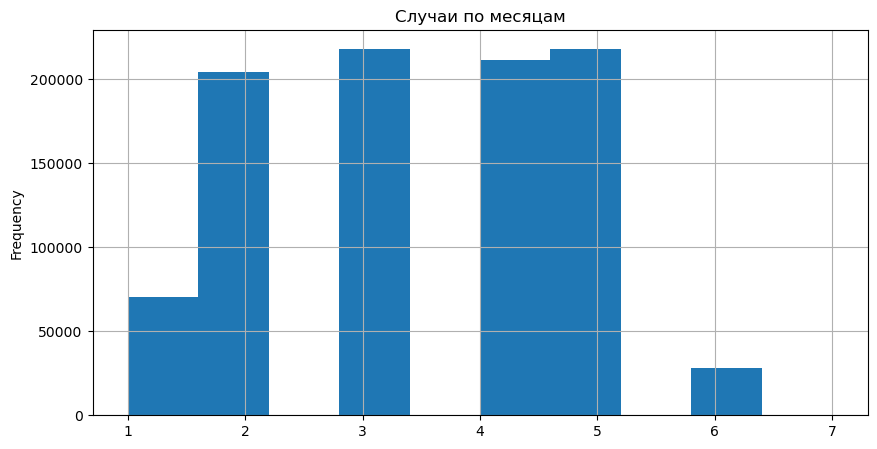

In [31]:
#строим столбчатую диаграмму

df['month'].plot(kind='hist', bins=10, title='Случаи по месяцам', figsize=(10,5), range=(1, 7), grid=True)
plt.show()

Мы видим, что наибольшее количество случаев распределено во 2, 3, 4 и 5 месяцах. 1 и 6 месяц это период начала и окончания эпидемии. 

### Анализ столбцов 'people_total_tested_count' и 'people_hospitalized_cumulative_count'

Проанализируем столбцы `people_total_tested_count` и `people_hospitalized_cumulative_count`, проверим для каких стран присутствуют данные и визуализируем их.

In [32]:
#сделаем срез данных, где не будет пропусков в столбцах

total_tested = df.query('people_total_tested_count >= 0 and people_hospitalized_cumulative_count >= 0')

#проверим уникальные значения
print(total_tested['country_region'].unique())
print(total_tested['month'].unique())

['US']
[4 5 6]


Как видим, данные в столбцах `people_total_tested_count` и `people_hospitalized_cumulative_count` предоставлены только для страны **США**, и только за 4-6 месяцы, скорее всего это связано с технической частью сбора информации.

In [33]:
#сгруппируем таблицу и посмотрим какой процент людей госпитализировали по штатам за три месяца

hospitalized = (total_tested
               .groupby('province_state')
               .agg({'people_total_tested_count' : 'mean', 'people_hospitalized_cumulative_count' : 'mean'})
               .reset_index()
               .sort_values(by='people_total_tested_count', ascending=False))

hospitalized['percent'] = round(hospitalized['people_hospitalized_cumulative_count'] / hospitalized['people_total_tested_count'] * 100, 2)


hospitalized

province_state  people_total_tested_count  \
34                  New York               1,207,977.67   
5                 California                 998,500.24   
10                   Florida                 571,051.50   
47                     Texas                 519,146.63   
15                  Illinois                 457,352.04   
32                New Jersey                 398,655.46   
23             Massachusetts                 365,962.74   
24                  Michigan                 298,111.11   
41              Pennsylvania                 285,917.35   
11                   Georgia                 259,476.22   
46                 Tennessee                 255,904.26   
52                Washington                 234,695.39   
20                 Louisiana                 229,913.19   
38                      Ohio                 211,457.20   
35            North Carolina                 209,733.81   
22                  Maryland                 164,880.72   
51                  Virginia                 156,408.67   
16                   Indiana                 144,645.87   
7                Connecticut                 139,939.28   
48                      Utah                 137,426.20   
54                 Wisconsin                 130,196.65   
25                 Minnesota                 123,347.04   
3                    Arizona                 122,608.46   
0                    Alabama                 122,259.67   
27                  Missouri                 114,346.13   
33                New Mexico                 103,531.52   
19                  Kentucky                 102,697.37   
6                   Colorado                 102,216.74   
39                  Oklahoma                 101,422.72   
44            South Carolina                 100,000.87   
26               Mississippi                  95,643.69   
43              Rhode Island                  88,448.31   
17                      Iowa                  78,691.24   
40                    Oregon                  77,528.13   
30                    Nevada                  70,696.28   
4                   Arkansas                  69,810.28   
53             West Virginia                  58,791.33   
18                    Kansas                  51,134.22   
29                  Nebraska                  49,466.00   
36              North Dakota                  41,646.06   
31             New Hampshire                  36,718.22   
13                    Hawaii                  36,600.72   
8                   Delaware                  33,557.31   
14                     Idaho                  30,917.07   
9       District of Columbia                  29,163.35   
1                     Alaska                  28,324.20   
21                     Maine                  26,768.96   
45              South Dakota                  24,553.09   
28                   Montana                  22,401.70   
49                   Vermont                  20,956.07   
55                   Wyoming                  13,960.96   
42               Puerto Rico                   5,998.20   
12                      Guam                   3,576.44   
37  Northern Mariana Islands                   2,469.54   
50            Virgin Islands                   1,096.06   
2             American Samoa                      77.91   

    people_hospitalized_cumulative_count  percent  
34                             69,258.94     5.73  
5                               1,428.28     0.14  
10                              7,057.02     1.24  
47                                440.13     0.08  
15                              1,317.93     0.29  
32                              5,361.07     1.34  
23                              6,945.26     1.90  
24                              1,017.63     0.34  
41                                766.70     0.27  
11                              5,771.69     2.22  
46                              1,228.37     0.48  
52                        

In [34]:
#проверим минимальное, максимальное и среднеее значение госпитализированных людей по всей стране

hospitalized.describe()

people_total_tested_count  people_hospitalized_cumulative_count  \
count                      56.00                                 56.00   
mean                  167,299.61                              2,625.72   
std                   224,945.68                              9,285.13   
min                        77.91                                  0.00   
25%                    35,839.87                                 73.36   
50%                   101,819.73                                620.79   
75%                   210,164.66                              1,546.46   
max                 1,207,977.67                             69,258.94   

       percent  
count    56.00  
mean      0.96  
std       1.21  
min       0.00  
25%       0.18  
50%       0.56  
75%       1.27  
max       5.73

Из полученных таблиц, мы видим, что наибольший процент госпитализированных людей **5.73%** приходится на штат **Нью-Йорк**. В среднем госпитализация за период апрель-июнь составляет **0.96%**.

Данных слишком мало, чтобы сделать окончательные выводы и посмотреть на динамику госпитазиции, по этому оставляем промежуточные выводы в таком формате.

### Топ-15 стран по наибольшему количеству случаев

Посмотрим как распределились случаи по странам, выделим топ-15 стран по наибольшему количеству случаев.

In [35]:
#сгруппируем данные по странам и количеству случаев

country_sum = (df
               .groupby('country_region')['cases']
               .sum()
               .reset_index()
               .sort_values(by='cases', ascending=False)
               .head(15))

country_sum.columns = ['country_region', 'total_cases']
country_sum

country_region  total_cases
173              US     77320973
85            Italy     15860457
157           Spain     15588817
177  United Kingdom     13312239
23           Brazil     12014992
62           France     11910574
139          Russia     11221535
66          Germany     11092057
36            China     10055264
81             Iran      7571624
172          Turkey      7536166
79            India      4528222
133            Peru      4085329
32           Canada      3973330
16          Belgium      3453474

In [36]:
#строим столбчатую диаграмму

fig = px.bar(country_sum, 
             x='country_region', 
             y='total_cases', 
             text='total_cases'
             )

fig.update_layout(title='Топ-15 стран по количеству случаев',
                  title_x=0.5,
                  xaxis_title='Страны',
                  yaxis_title='Количество случаев')


fig.show()

Из всех стран, на графике, сильно выделяется **US** с количеством случаев **77 320 973**, далее идут страны с небольшим разрывом **Италия, Испания** с количеством случаев **15 860 457 и 15 588 817** соответственно. В данной подборке наименьшее количество случаев **3 453 474** имеет **Бельгия**.

Теперь посмотрим как распределились случаи по типам в Топ-15 странах.

In [37]:
#создаем лист в который поместим наименования топ-15 стран

top_15_list = country_sum['country_region'].tolist()

In [38]:
#теперь делаем срез датафрейма

top_15_cases = df.query('country_region in @top_15_list')

In [39]:
#сгруппируем данные по страннам и типу случая

top_15_ct = pd.pivot_table(top_15_cases, 
                           values=['cases'],
                           index=['country_region', 'case_type'],
                           aggfunc={'cases': "sum"}).reset_index()

top_15_ct.columns = ['country_region', 'case_type', 'sum']

top_15_ct

country_region  case_type       sum
0          Belgium  Confirmed   3005609
1          Belgium     Deaths    447865
2           Brazil  Confirmed  11310710
3           Brazil     Deaths    704282
4           Canada  Confirmed   3727966
5           Canada     Deaths    245364
6            China  Confirmed   9628865
7            China     Deaths    426399
8           France  Confirmed  10441318
9           France     Deaths   1469256
10         Germany  Confirmed  10695564
11         Germany     Deaths    396493
12           India  Confirmed   4395537
13           India     Deaths    132685
14            Iran  Confirmed   7148362
15            Iran     Deaths    423262
16           Italy  Confirmed  13991688
17           Italy     Deaths   1868769
18            Peru  Confirmed   3973392
19            Peru     Deaths    111937
20          Russia  Confirmed  11108581
21          Russia     Deaths    112954
22           Spain  Confirmed  14042683
23           Spain     Deaths   1546134
24          Turkey  Confirmed   7342848
25          Turkey     Deaths    193318
26              US  Confirmed  73158080
27              US     Deaths   4162893
28  United Kingdom  Confirmed  11634123
29  United Kingdom     Deaths   1678116

In [40]:
#теперь добавим общее количество случаев для страны объеденив таблицы

merged_top_15 = top_15_ct.merge(country_sum, on="country_region", how="left")

#рассчитаем процент распределения случаев
merged_top_15['percent'] = round(merged_top_15['sum'] / merged_top_15['total_cases'] * 100, 2)

merged_top_15

country_region  case_type       sum  total_cases  percent
0          Belgium  Confirmed   3005609      3453474    87.03
1          Belgium     Deaths    447865      3453474    12.97
2           Brazil  Confirmed  11310710     12014992    94.14
3           Brazil     Deaths    704282     12014992     5.86
4           Canada  Confirmed   3727966      3973330    93.82
5           Canada     Deaths    245364      3973330     6.18
6            China  Confirmed   9628865     10055264    95.76
7            China     Deaths    426399     10055264     4.24
8           France  Confirmed  10441318     11910574    87.66
9           France     Deaths   1469256     11910574    12.34
10         Germany  Confirmed  10695564     11092057    96.43
11         Germany     Deaths    396493     11092057     3.57
12           India  Confirmed   4395537      4528222    97.07
13           India     Deaths    132685      4528222     2.93
14            Iran  Confirmed   7148362      7571624    94.41
15            Iran     Deaths    423262      7571624     5.59
16           Italy  Confirmed  13991688     15860457    88.22
17           Italy     Deaths   1868769     15860457    11.78
18            Peru  Confirmed   3973392      4085329    97.26
19            Peru     Deaths    111937      4085329     2.74
20          Russia  Confirmed  11108581     11221535    98.99
21          Russia     Deaths    112954     11221535     1.01
22           Spain  Confirmed  14042683     15588817    90.08
23           Spain     Deaths   1546134     15588817     9.92
24          Turkey  Confirmed   7342848      7536166    97.43
25          Turkey     Deaths    193318      7536166     2.57
26              US  Confirmed  73158080     77320973    94.62
27              US     Deaths   4162893     77320973     5.38
28  United Kingdom  Confirmed  11634123     13312239    87.39
29  United Kingdom     Deaths   1678116     13312239    12.61

In [41]:
# строим столбчатую диаграмму 
fig = px.bar(merged_top_15,
             x='sum',
             y='country_region',
             text='percent',
             template='plotly_white',                    
             color='case_type')

fig.update_layout(title='Распределение случаев в Топ-15 странах',
                  title_x=0.5,
                  xaxis_title='Количество случаев',
                  yaxis_title='Наименование страны',
                  legend_title_text='Тип случая',
                  yaxis={'categoryorder':'total ascending'})
fig.show()

Из графика видно, что наибольшая доля смертей приходиться на такие страны как **Бельгия - 12.97 %, Великобритания - 12.61 %, Франция - 12.34 %, Италия - 11.78 %**, наименьшая доля смертей приходится на **Россию - 1.01 %**. Несмотря на то, что в США наибольшее количество случаев заражения Covid-19, смертность составляет 5.38 %.

In [42]:
#создадим сводную таблицу, чтобы увидеть распределение случаев по месяцам
by_month = pd.pivot_table(top_15_cases,
                              index= 'month',
                              columns = 'country_region',
                              values='cases',
                              aggfunc='sum')
by_month

country_region  Belgium   Brazil   Canada    China   France  Germany    India  \
month                                                                           
1                     0        0       12    38897       30       18        2   
2                    26        5      234  1679778      485      561       84   
3                 92154    38103    52385  2613914   431646   592055    10478   
4               1126277  1115077   970097  2618433  4208966  4058195   462024   
5               1962372  8453315  2543323  2749044  6393879  5670807  3182648   
6                272645  2408492   407279   355198   875568   770421   872986   

country_region     Iran    Italy     Peru   Russia    Spain   Turkey  \
month                                                                  
1                     0        2        0        2        0        0   
2                  1788     4068        0       58      151        0   
3                560147  1326388     7844    12278   797125    59752   
4               2397160  5572695   422000  1139560  5784937  2147799   
5               3943653  7888448  2934102  8339406  7937533  4646072   
6                668876  1068856   721383  1730231  1069071   682543   

country_region        US  United Kingdom  
month                                     
1                     38               2  
2                    379             242  
3                1112160          177974  
4               20512178         3497491  
5               47903102         8356676  
6                7793116         1279854

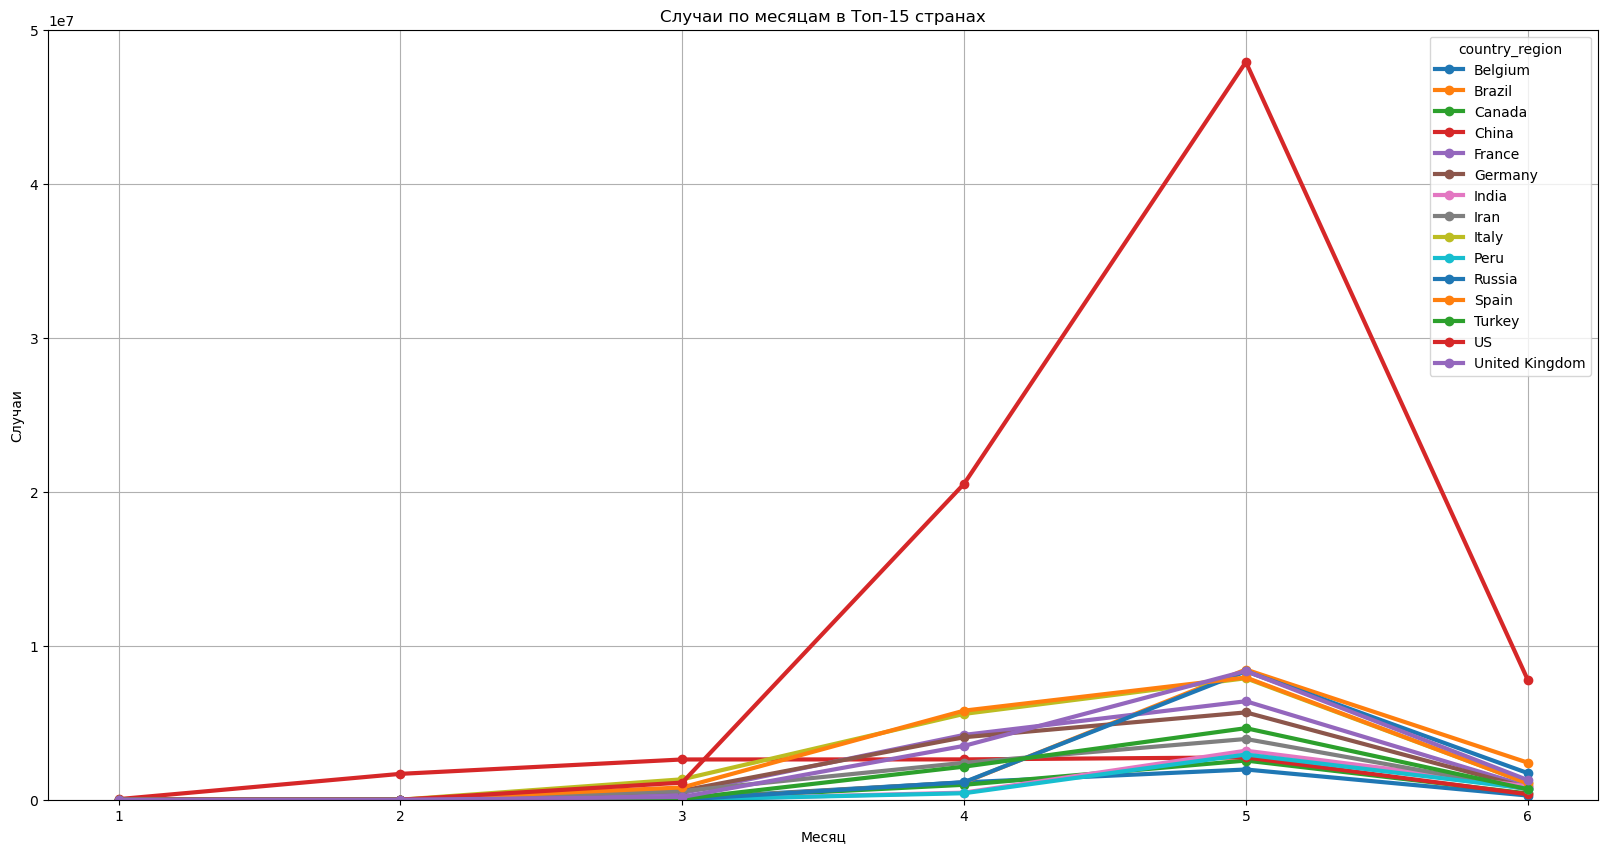

In [43]:
by_month.plot(figsize=(20,10), ylim=(0,50000000), grid=True, title='Случаи по месяцам в Топ-15 странах', style='o-', linewidth=3, xlabel="Месяц", ylabel="Случаи")
plt.show()

Мы видим, что у **Китая** раньше всех начало расти количество случаев, но за весь период оно не привышало отметки в **5 млн.**, а также на графике для Китая нет четко выраженных скачков, а вот в остальных странах резкий скачок роста количества случаев мы видим с третьего по пятый месяц и резкий спад с пятого по шестой. В **Бельгии** вспышка эпидемии произошла с четверго месяца и практически достигла отметки в **1 млн.**, но с пятого месяца также произошел резкий спад. На графике сильно выделяется **США**, количество случаев с 3 по 4 месяц увеличилось с **1 млн. до 20 млн.**, а в мае уже до **47 млн.**, в июне количество случаев снизилось до **7 млн.**

### Топ-5 стран по наименьшему количеству случаев

Теперь выполнем все те же действия, только для пяти стран, у которых было наименьшее количество случаев.

In [44]:
#сгруппируем данные по странам и количеству случаев

country_sum_2 = (df
               .groupby('country_region')['cases']
               .sum()
               .reset_index()
               .sort_values(by='cases', ascending=True)
               .head(5))

country_sum_2.columns = ['country_region', 'total_cases']
country_sum_2

country_region  total_cases
98            Lesotho           41
183    Western Sahara          398
131  Papua New Guinea          431
75           Holy See          720
149        Seychelles          821

In [45]:
#строим столбчатую диаграмму

fig = px.bar(country_sum_2, 
             x='country_region', 
             y='total_cases', 
             text='total_cases'
             )

fig.update_layout(title='Топ-5 стран по наименьшему количеству случаев',
                  title_x=0.5,
                  xaxis_title='Страны',
                  yaxis_title='Количество случаев')


fig.show()

Наименьшее количество случаев, за указанный период, зафиксировано в **Лесото - 41**, далее идут **Западная Сахара, Папуа-Новая Гвинея, Ватикан и Сейшелы - 398, 431, 720 и 821** случаев.

In [46]:
#создаем лист в который поместим наименования топ-15 стран

top_5_list = country_sum_2['country_region'].tolist()

In [47]:
#теперь делаем срез датафрейма

top_5_cases = df.query('country_region in @top_5_list')

In [48]:
#сгруппируем данные по страннам и типу случая

top_5_ct = pd.pivot_table(top_5_cases, 
                           values=['cases'],
                           index=['country_region', 'case_type'],
                           aggfunc={'cases': "sum"}).reset_index()

top_5_ct.columns = ['country_region', 'case_type', 'sum']

top_5_ct

country_region  case_type  sum
0          Holy See  Confirmed  720
1          Holy See     Deaths    0
2           Lesotho  Confirmed   41
3           Lesotho     Deaths    0
4  Papua New Guinea  Confirmed  431
5  Papua New Guinea     Deaths    0
6        Seychelles  Confirmed  821
7        Seychelles     Deaths    0
8    Western Sahara  Confirmed  388
9    Western Sahara     Deaths   10

In [49]:
#теперь добавим общее количество случаев для страны объеденив таблицы

merged_top_5 = top_5_ct.merge(country_sum_2, on="country_region", how="left")

#рассчитаем процент распределения случаев
merged_top_5['percent'] = round(merged_top_5['sum'] / merged_top_5['total_cases'] * 100, 2)

merged_top_5

country_region  case_type  sum  total_cases  percent
0          Holy See  Confirmed  720          720   100.00
1          Holy See     Deaths    0          720     0.00
2           Lesotho  Confirmed   41           41   100.00
3           Lesotho     Deaths    0           41     0.00
4  Papua New Guinea  Confirmed  431          431   100.00
5  Papua New Guinea     Deaths    0          431     0.00
6        Seychelles  Confirmed  821          821   100.00
7        Seychelles     Deaths    0          821     0.00
8    Western Sahara  Confirmed  388          398    97.49
9    Western Sahara     Deaths   10          398     2.51

In [50]:
# строим столбчатую диаграмму 
fig = px.bar(merged_top_5,
             x='sum',
             y='country_region',
             text='percent',
             template='plotly_white',                    
             color='case_type')

fig.update_layout(title='Распределение случаев в Топ-5 странах',
                  title_x=0.5,
                  xaxis_title='Количество случаев',
                  yaxis_title='Наименование страны',
                  legend_title_text='Тип случая',
                  yaxis={'categoryorder':'total ascending'})
fig.show()

Из графика видно, что случаи смертей зафиксированы только в **Западной Сахаре - 2.51 %**

In [51]:
#создадим сводную таблицу, чтобы увидеть распределение случаев по месяцам
by_month_2 = pd.pivot_table(top_5_cases,
                              index= 'month',
                              columns = 'country_region',
                              values='cases',
                              aggfunc='sum')
by_month_2

country_region  Holy See  Lesotho  Papua New Guinea  Seychelles  \
month                                                             
1                      0        0                 0           0   
2                      0        0                 0           0   
3                     58        0                12         111   
4                    247        0               139         325   
5                    367       29               248         341   
6                     48       12                32          44   

country_region  Western Sahara  
month                           
1                            0  
2                            0  
3                            0  
4                          142  
5                          216  
6                           40

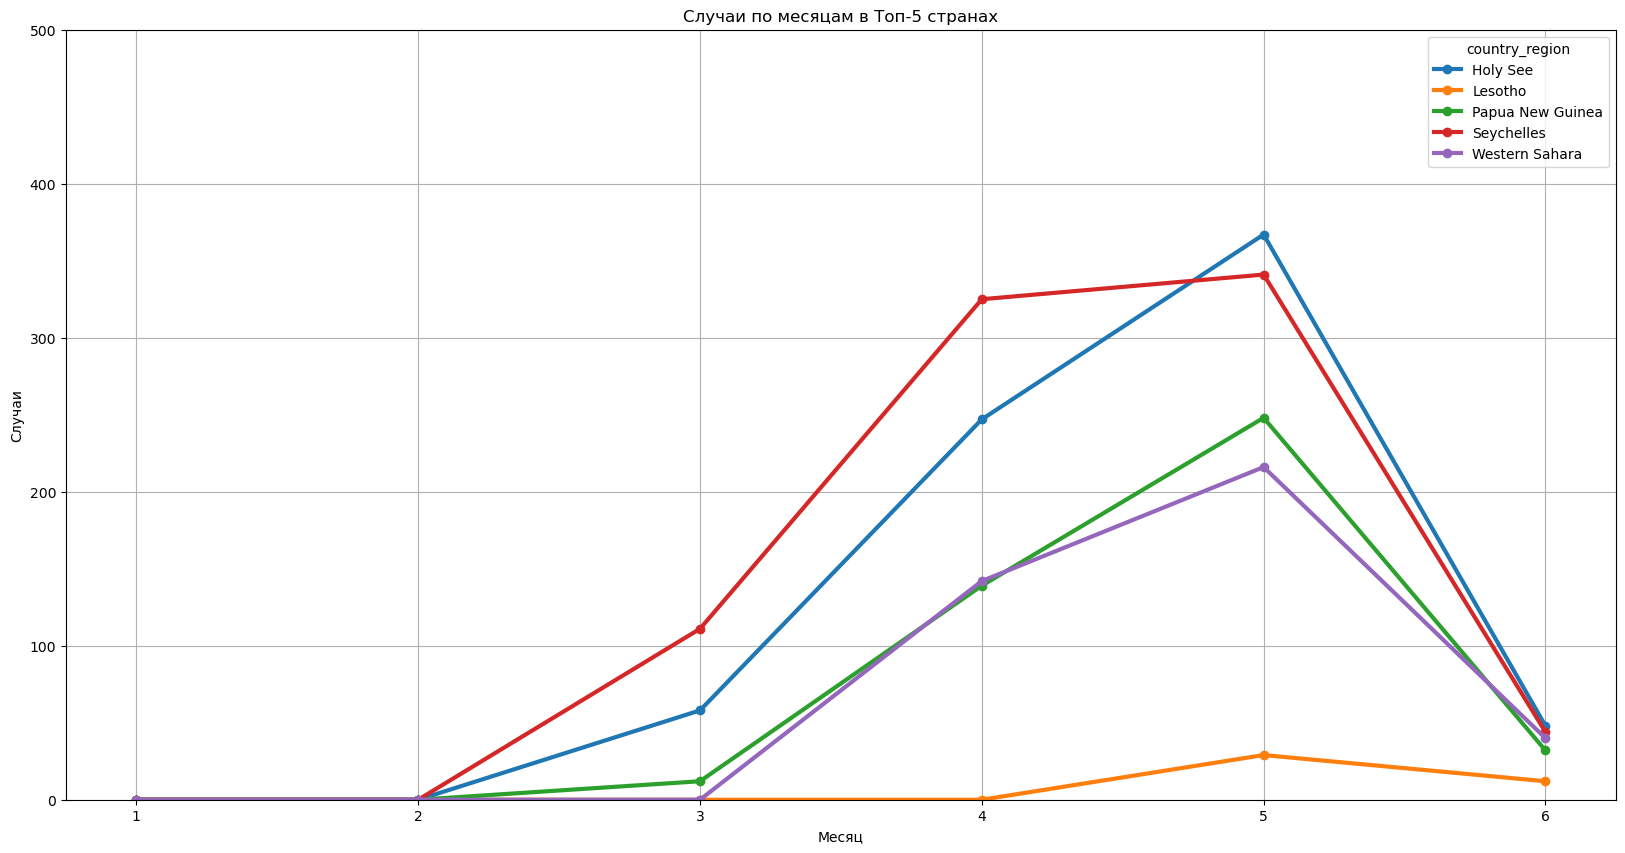

In [52]:
# строим график
by_month_2.plot(figsize=(20,10), ylim=(0,500), grid=True, title='Случаи по месяцам в Топ-5 странах', style='o-', linewidth=3, xlabel="Месяц", ylabel="Случаи")
plt.show()

Закономерность роста и спада эпидемии в Топ-5 странах, по наименьшему количеству случаев, такая же. Ватикан и Сейшелы лидируют по количеству случаев  и пересекли отметку в 300 с 4 по  5 месяц.

### Исследование случаев в США по штатам

Так как США является лидером по количеству случаев за предоставленный период данных, мы изучим их более детально - по штатам.

In [53]:
#делаем срез данных, в котором оставим только страну US

df_us = df.query('country_region == "US"')
df_us.head(2)

case_type  people_total_tested_count  cases  difference       date  \
67083  Confirmed                        NaN      0           0 2020-03-09   
67084     Deaths                        NaN      0           0 2020-02-02   

                combined_key country_region province_state   admin2 iso2 iso3  \
67083  Grayson, Kentucky, US             US       Kentucky  Grayson   US  USA   
67084     Floyd, Indiana, US             US        Indiana    Floyd   US  USA   

           fips   lat   long  population_count  \
67083 21,085.00 37.46 -86.34         26,427.00   
67084 18,043.00 38.32 -85.90         78,522.00   

       people_hospitalized_cumulative_count  \
67083                                   NaN   
67084                                   NaN   

                                                                             data_source  \
67083  2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE   
67084  2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE   

          prep_flow_runtime    population  month  
67083  6/4/2020 11:15:39 PM 10,237,840.63      3  
67084  6/4/2020 11:15:39 PM 10,237,840.63      2

In [54]:
#сгруппируем данные по штатам и количеству случаев

by_state = (df_us
            .groupby('province_state')['cases']
            .sum()
            .reset_index()
            .sort_values(by='cases', ascending=False))

by_state.columns = ['province_state', 'total_cases']
print(by_state.head())
print('*'*40)
print(by_state.tail())

   province_state  total_cases
34       New York     20347009
32     New Jersey      7859785
15       Illinois      4324976
23  Massachusetts      4240572
5      California      3991749
****************************************
              province_state  total_cases
1                     Alaska        23718
12                      Guam        10208
50            Virgin Islands         4334
37  Northern Mariana Islands         1188
2             American Samoa            0


In [55]:
by_state_1 = by_state.query('province_state != "New York"')

In [56]:
#строим столбчатую диаграмму

fig = px.bar(by_state_1, 
             x='province_state', 
             y='total_cases', 
             text='total_cases'
             )

fig.update_layout(title='Количество случаев в США по штатам',
                  title_x=0.5,
                  xaxis_title='Штаты',
                  yaxis_title='Количество случаев',
                  width=1200,
                  height=500)


fig.show()

Наибольшее количество случаев зафиксировано в штате **Нью-Йорк - 20 347 009**, на втором месте **Нью-Джерси - 7 859 785**, все остальные штаты не преодолели отметку в 5 млн. Меньше всего зафиксировано случаев в штатах **Virgin Islands и Northern Mariana Islands - 4 343 и 1 188**, на острове  **American Samoa** случаи не зафиксированы и равны нулю.

In [57]:
#прочитаем файл с границами штатов и сохраним его в переменную

with open('us-states.json', 'r') as f:
    state_geo = json.load(f)

In [58]:
# usa_lat - широта центра США, usa_lng - долгота центра США
us_lat, us_lng = 39.50, -98.35

# создаём карту США
m = Map(location=[us_lat, us_lng], zoom_start=3)

In [59]:
# создаём хороплет с помощью конструктора Choropleth и добавляем его на карту
Choropleth(
    geo_data=state_geo,
    data=by_state,
    columns=['province_state', 'total_cases'],
    key_on='feature.properties.name',
    fill_color='RdPu',
    fill_opacity=0.9,
    legend_name='Количество случаев по штатам',
).add_to(m)

m

In [60]:
#отобразим все случаи смертей на карте

us_death = df_us.query('case_type == "Deaths"')

In [61]:
# создаём карту США
m = Map(location=[us_lat, us_lng], zoom_start=3)

# создаём пустой кластер, добавляем его на карту
marker_cluster = MarkerCluster().add_to(m)

In [62]:
# пишем функцию, которая принимает строку датафрейма,
# создаёт маркер в текущей точке и добавляет его в кластер marker_cluster

#def create_clusters(row):
    #Marker(
        #[row['lat'], row['long']],
        #popup=f"{row['combined_key']} {row['population_count']}",
    #).add_to(marker_cluster)

# применяем функцию create_clusters() к каждой строке датафрейма
#us_death.apply(create_clusters, axis=1)

# выводим карту
#m

Мы видим, что наибольшее количество смертей распределены в центральной и западной части страны.

### Корреляция

Проверим если влияние количества населения и расположения страны на количество случаев.

In [63]:
#считаем корреляцию

print('Корреляция между случаями и популяцией страны составляет:', df['cases'].corr(df['population']))
print('Корреляция между случаями и расположением страны составляет:', df['cases'].corr(df['lat']))

Корреляция между случаями и популяцией страны составляет: 0.04007706726330134
Корреляция между случаями и расположением страны составляет: -0.006636031449766244


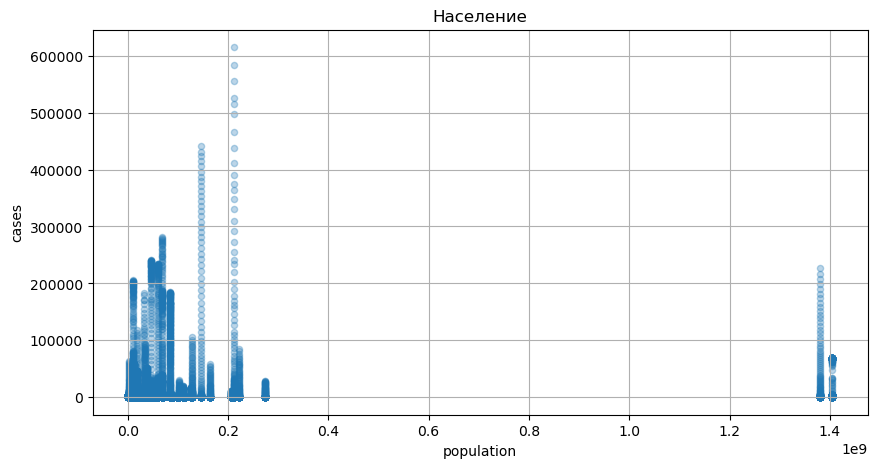

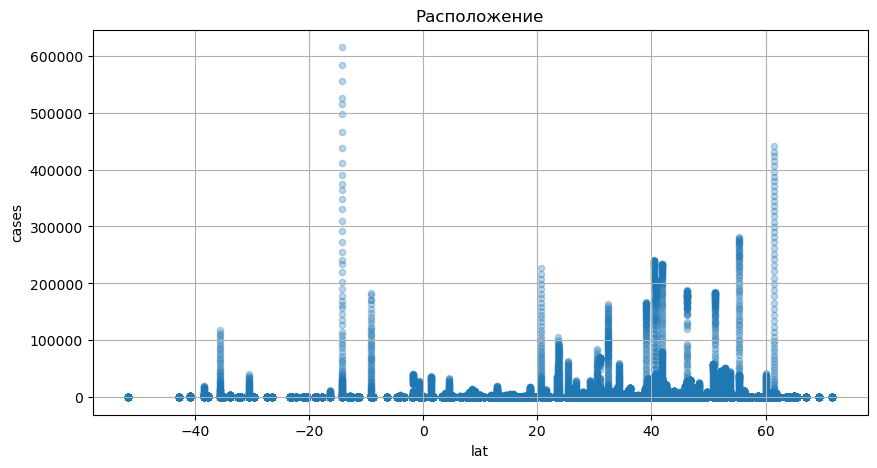

In [64]:
#строим графики рассеивания

df.plot(x='population', y='cases', kind='scatter', grid=True, figsize=(10,5), alpha=0.3, title='Население')
plt.show()
df.plot(x='lat', y='cases', kind='scatter', grid=True, figsize=(10,5), alpha=0.3, title='Расположение')
plt.show()

Как видим из рассчета и графика, количество случаев заражения Covid-19 в стране, за период 22.01.2020 - 04.06.2020, не зависит от его населения и расположения.

In [65]:
#посмотрим на корреляцию для штатов в США

print('Корреляция между случаями и населением штатов составляет:', df_us['cases'].corr(df_us['population_count']))
print('Корреляция между случаями и расположением штатов составляет:', df_us['cases'].corr(df_us['lat']))

Корреляция между случаями и населением штатов составляет: 0.3251419305482126
Корреляция между случаями и расположением штатов составляет: 0.006447084161141801


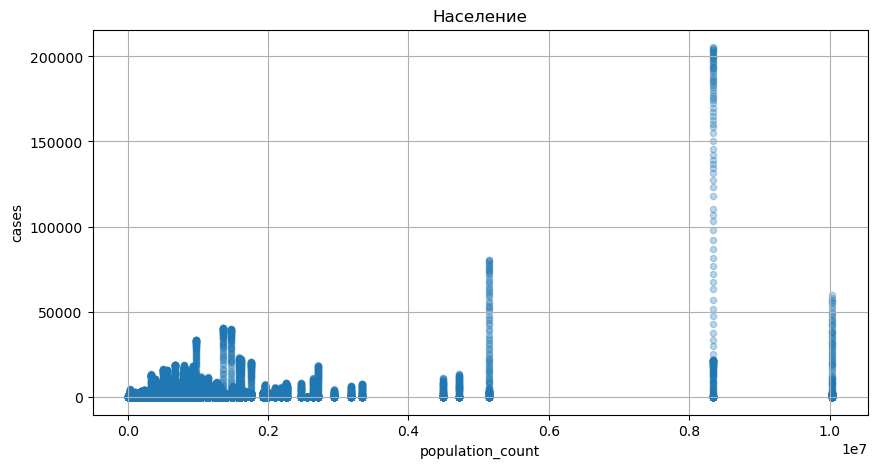

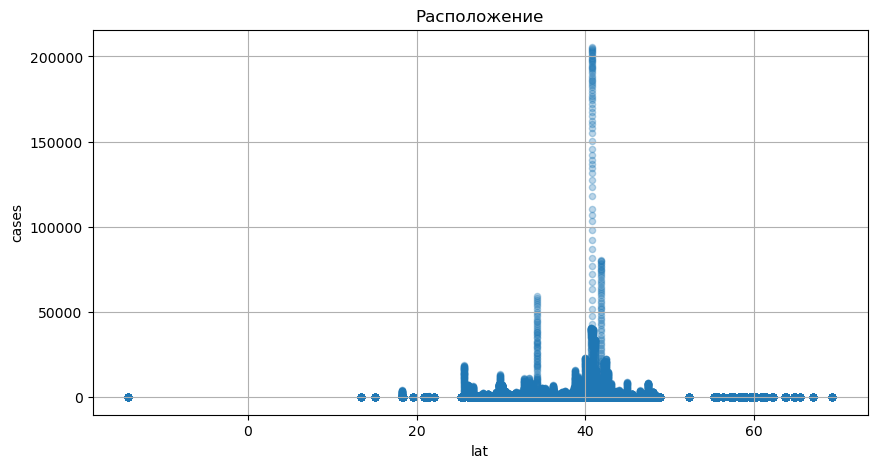

In [66]:
#строим графики рассеивания

df_us.plot(x='population_count', y='cases', kind='scatter', grid=True, figsize=(10,5), alpha=0.3, title='Население')
plt.show()
df_us.plot(x='lat', y='cases', kind='scatter', grid=True, figsize=(10,5), alpha=0.3, title='Расположение')
plt.show()

Корреляция между случаями и населением штатов немного больше чем для всего мира вцелом, но составляет менее 0.5. По этому зависимости между случаями и населением в штатах, как и в расположении их, нет. 

## Выводы:

Мы проанализировали датафрейм `COVID-19 Cases.csv`, который был взят из открытого источника `https://data.world` и определили следующие факторы:
  1. В датафрейме представлено **950 670 строк и 18 столбцов**. Данные были выгружены из ресурса _"2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE" - 4 июня 2020 года, ночью._
  2. Были выявлены пропуски в следующих столбцах: №1 и №15 (количество протестированных и госпитазированных людей), пропуски составляют 99%, которые заполнить невозможно, т.к. у нас нет данных о количестве поступивших людей для проведения теста. Пропуски с №7 по №11 столбцы (маркировка для отдельных регионов), заменили на обозначение NI (no information), а также для столбца FIPS - пропуски заменили на 0. В столбцах №12, №13 и №14 (координаты и население) пропуски заменили медианным значением, т.к. многие населенные пункты находятся вне штата, мы не можем узнать точные координаты из открытых источников, но таким образом мы привязали места к штату, в котором хранится информация о случаях. Для городов Китая, Гонконг и Макао, а также для лайнера, заменили пропуски информацией за 2020 год из открытых источников.
  3. В датафрейм собраны случаи за период **22.01.2020 - 04.06.2020 (135 дней)**. Данные собраны для **186 стран и 1 круизного корабля.**
  4. Были выявлены такие аномалии как: количество протестированных людей более **2 млн., 614 тысяч подтвержденных случаев, население 1.38 млрд**. Данные цифры можно обосновать тем, что в данных есть такие густонаселенные страны как Китай и Индия. И т.к. нам необходимы все данные для состаления точного анализа по всему миру - данные выбросы были осталены в датафрейме.
  5. За пять месяцев 2020 года количество умерших от Covid-19 составило **15 838 408 человек (6.09 %)**, а с положительным тестом зафиксировано - **244 187 571 (93.9 %)**. Всего зафиксировано случаев **260 025 979.**
  6. Наибольшее количество случаев распределено со 2 по 5 месяц, что можно определить как период вспышки эпидемии, а 1 и 6 месяц это период её начала и окончания. 
  7. Наибольший процент госпитализированных людей **5.73%** приходится на штат **Нью-Йорк**. В среднем госпитализация за период апрель-июнь составляет **0.96%**. Но данных слишком мало, чтобы отследить динамику госпитализации по месяцам.
  8. Было определены Топ-15 стран по наибольшему количеству случаев, из которых сильно выделяется **US** с количеством случаев **77 320 973**, далее идут страны с небольшим разрывом **Италия, Испания** с количеством случаев **15 860 457 и 15 588 817** соответственно. В данной подборке наименьшее количество случаев **3 453 474** имеет **Бельгия**. Для данных стран наибольшая доля смертей приходиться на **Бельгию - 12.97 %, Великобританию - 12.61 %, Францию - 12.34 %, Италию - 11.78 %**, наименьшая доля смертей приходится на **Россию - 1.01 %**. Несмотря на то, что в США наибольшее количество случаев заражения Covid-19, смертность составляет **5.38 %.**
  9. Определили Топ-5 стран по наименьшему количеству случаев: это **Лесото - 41**, далее идут **Западная Сахара, Папуа-Новая Гвинея, Ватикан и Сейшелы - 398, 431, 720 и 821**. Случаи смертей зафиксированы только в **Западной Сахаре - 2.51 %**.
  10. Был проведен отдельный анализ для штатов США. Наибольшее количество случаев зафиксировано в штате **Нью-Йорк - 20 347 009**, на втором месте **Нью-Джерси - 7 859 785**, все остальные штаты не преодолели отметку в 5 млн. Меньше всего зафиксировано случаев в штатах **Virgin Islands и Northern Mariana Islands - 4 343 и 1 188**, на острове  **American Samoa** случаи не зафиксированы и равны нулю.
  11. Визуализировали графики для Топ-15 и Топ-5 стран и выявили, что незначительный рост случаев был зафиксирован со 2-3 месяцы, а резкий скачок Covid-19 был с 3-5 месяцы, с 5-6 резкий спад эпидемии. 
  12. Расчитали корреляцию между количеством случаев и популяцией **(0.04)**, а также между случаями и расположением страны **(-0.006)** и определили, что зависимости между данными параметрами нет. Население страны и её расположение не влияют на количество случаев.